Device: cpu
[Adam] Epoch 1/80 train_loss=0.086584 val_loss=0.351303 lr=1.00e-03
[Adam] Epoch 5/80 train_loss=0.011589 val_loss=0.067905 lr=1.00e-03
[Adam] Epoch 10/80 train_loss=0.007726 val_loss=0.040083 lr=1.00e-03
[Adam] Epoch 15/80 train_loss=0.006221 val_loss=0.028169 lr=1.00e-03
[Adam] Epoch 20/80 train_loss=0.005358 val_loss=0.022268 lr=1.00e-03
[Adam] Epoch 25/80 train_loss=0.004624 val_loss=0.019161 lr=1.00e-03
[Adam] Epoch 30/80 train_loss=0.004432 val_loss=0.017783 lr=1.00e-03
[Adam] Epoch 35/80 train_loss=0.004438 val_loss=0.018270 lr=1.00e-03
[Adam] Epoch 40/80 train_loss=0.004080 val_loss=0.010001 lr=5.00e-04
[Adam] Epoch 45/80 train_loss=0.003842 val_loss=0.008354 lr=5.00e-04
[Adam] Epoch 50/80 train_loss=0.003635 val_loss=0.008887 lr=2.50e-04
[Adam] Epoch 55/80 train_loss=0.003612 val_loss=0.007163 lr=2.50e-04
[Adam] Epoch 60/80 train_loss=0.003617 val_loss=0.007548 lr=2.50e-04
[Adam] Epoch 65/80 train_loss=0.003660 val_loss=0.007286 lr=1.25e-04
Early stopping at epoch 

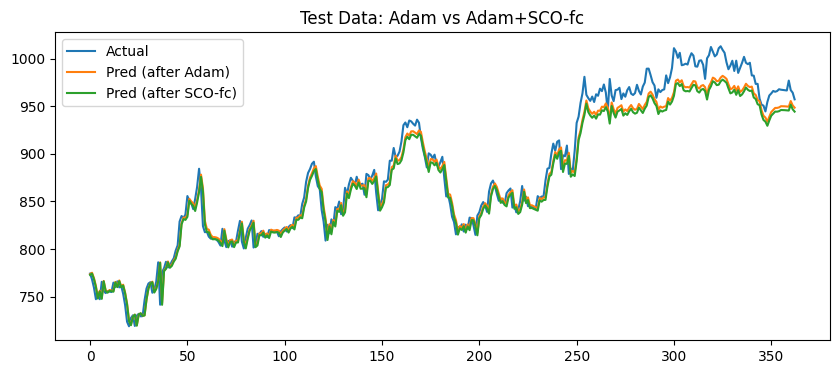

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math
import random
import time
import os

# ---------------- reproducibility ----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ---------------- device ----------------
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


data_dir = "../Data"  # path where your CSVs are stored
ticker = 'HDFCBANK.NS'
csv_path = os.path.join(data_dir, f"{ticker}_features.csv")

# Load CSV
stock_data = pd.read_csv(csv_path)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.reset_index(drop=True, inplace=True)


# Use Close only (keeps pipeline similar), but could add more features later
data = stock_data[['Date', 'Close']].copy()
data['Date'] = pd.to_datetime(data['Date'])

# ---------------- prepare dataframe function ----------------
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)

X = shifted_df.drop('Close', axis=1).values    # shape (N, lookback)
y = shifted_df['Close'].values                 # shape (N,)

# ---------------- scalers ----------------
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y = scaler_y.fit_transform(y.reshape(-1, 1))

# keep your original flip
X = dc(np.flip(X, axis=1))

split_index = int(len(X) * 0.70)
X_train_np, X_test_np = X[:split_index], X[split_index:]
y_train_np, y_test_np = y[:split_index], y[split_index:]

# torch tensors
X_train = torch.tensor(X_train_np.reshape((-1, lookback, 1))).float()
X_test = torch.tensor(X_test_np.reshape((-1, lookback, 1))).float()
y_train = torch.tensor(y_train_np).float()
y_test = torch.tensor(y_test_np).float()

# ---------------- dataset / dataloader ----------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=16, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=16, shuffle=False)

# ---------------- model (bigger but still small) ----------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# instantiate
hidden_size = 64
num_layers = 2
dropout = 0.2
model = LSTMModel(1, hidden_size, num_layers, dropout).to(device)
loss_function = nn.MSELoss()

# --------------- helper functions ---------------
def evaluate_loss_on_loader(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out, yb)
            b = xb.size(0)
            total_loss += loss.item() * b
            total_samples += b
    return total_loss / max(1, total_samples)

def get_flat_params_from_module(module):
    return torch.cat([p.data.view(-1) for p in module.parameters()]).detach()

def set_flat_params_to_module(module, flat_params):
    idx = 0
    for p in module.parameters():
        n = p.numel()
        p.data.copy_(flat_params[idx: idx + n].view_as(p).to(p.device))
        idx += n

# --------------- Adam pretraining with early stopping & scheduler ---------------
pretrain_epochs = 80            # increase if you want
patience = 10                   # early stopping patience on val loss
clip_value = 1.0

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# Removed `verbose` argument for compatibility with PyTorch builds that don't accept it:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val = float('inf')
best_state = None
no_improve = 0

for epoch in range(pretrain_epochs):
    model.train()
    running = 0.0
    count = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_function(out, yb)
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running += loss.item() * xb.size(0)
        count += xb.size(0)
    train_loss = running / max(1, count)
    val_loss = evaluate_loss_on_loader(model, test_loader, loss_function, device)

    # step the scheduler (ReduceLROnPlateau expects the metric)
    scheduler.step(val_loss)

    # manual LR print for visibility (since we removed verbose)
    current_lr = optimizer.param_groups[0]['lr']
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"[Adam] Epoch {epoch+1}/{pretrain_epochs} train_loss={train_loss:.6f} val_loss={val_loss:.6f} lr={current_lr:.2e}")

    # early stopping
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
        break

# restore best state if found
if best_state is not None:
    model.load_state_dict(best_state)

# Metrics after Adam
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(device)).cpu().numpy()
    test_pred = model(X_test.to(device)).cpu().numpy()

train_pred_inv = scaler_y.inverse_transform(train_pred)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_train_inv = scaler_y.inverse_transform(y_train.cpu().numpy())
y_test_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

mae_adam = mean_absolute_error(y_test_inv.flatten(), test_pred_inv.flatten())
rmse_adam = math.sqrt(mean_squared_error(y_test_inv.flatten(), test_pred_inv.flatten()))
mape_adam = mean_absolute_percentage_error(y_test_inv.flatten(), test_pred_inv.flatten()) * 100
acc_adam = 100 - mape_adam

print("\nAfter Adam pretraining (metrics):")
print(f"MAE: {mae_adam:.4f}")
print(f"RMSE: {rmse_adam:.4f}")
print(f"MAPE: {mape_adam:.3f}%")
print(f"Calculated Accuracy: {acc_adam:.3f}%")

# --------------- SandCat-style fine-tune on final fc layer only ---------------
class SandCatFC:
    """
    SCO-style optimizer but only optimizing the small fc layer of the model.
    This is much safer and faster than modifying whole-network weights.
    """
    def __init__(self, n_agents=20, sigma=0.02, device='cpu', verbose=True):
        self.n_agents = int(n_agents)
        self.sigma = float(sigma)
        self.device = device
        self.verbose = verbose

    def optimize(self, model, train_loader, val_loader, loss_fn, epochs=10):
        # module to optimize
        module = model.fc
        best_pos = get_flat_params_from_module(module).to(self.device).clone()
        dim = best_pos.numel()
        # small scale based on magnitude
        base_scale = (best_pos.abs() + 1.0).to(self.device)
        # init population around best_pos
        pop = best_pos.unsqueeze(0).repeat(self.n_agents, 1) + \
              (self.sigma * torch.randn(self.n_agents, dim, device=self.device) * base_scale.unsqueeze(0))

        best_score = float('inf')
        for it in range(epochs):
            if self.verbose:
                print(f"[SCO-FC] iter {it+1}/{epochs} evaluating {self.n_agents} agents...")
            scores = []
            for i in range(self.n_agents):
                cand = pop[i]
                set_flat_params_to_module(module, cand)
                train_loss = evaluate_loss_on_loader(model, train_loader, loss_fn, self.device)
                scores.append(train_loss)
            scores = np.array(scores, dtype=float)
            argmin = int(np.argmin(scores))
            if scores[argmin] < best_score:
                best_score = float(scores[argmin])
                best_pos = pop[argmin].clone()

            # set best found, report train/val
            set_flat_params_to_module(module, best_pos)
            tr = evaluate_loss_on_loader(model, train_loader, loss_fn, self.device)
            va = evaluate_loss_on_loader(model, val_loader, loss_fn, self.device) if val_loader is not None else None
            if self.verbose:
                if va is not None:
                    print(f"[SCO-FC] iter {it+1} best_train={tr:.6f} best_val={va:.6f}")
                else:
                    print(f"[SCO-FC] iter {it+1} best_train={tr:.6f}")

            # shrink search radius and re-sample
            a = 2 * (1 - (it / max(1, epochs)))  # decreases approx 2 -> 0
            spread = (self.sigma * (a * 0.5 + 0.01)) * base_scale.unsqueeze(0)
            pop = best_pos.unsqueeze(0).repeat(self.n_agents, 1) + torch.randn(self.n_agents, dim, device=self.device) * spread
            pop[0] = best_pos.clone()

        # finalize
        set_flat_params_to_module(module, best_pos)
        return best_score

# run SCO on fc
sco = SandCatFC(n_agents=24, sigma=0.02, device=device, verbose=True)
sco_epochs = 12
start_time = time.time()
best_sco_train_loss = sco.optimize(model, train_loader, test_loader, loss_function, epochs=sco_epochs)
elapsed = time.time() - start_time
print(f"SCO fine-tune (fc) finished in {elapsed:.1f}s, best SCO train loss: {best_sco_train_loss:.6f}")

# --------------- Evaluate final metrics ---------------
model.eval()
with torch.no_grad():
    train_pred2 = model(X_train.to(device)).cpu().numpy()
    test_pred2 = model(X_test.to(device)).cpu().numpy()

train_pred2_inv = scaler_y.inverse_transform(train_pred2)
test_pred2_inv = scaler_y.inverse_transform(test_pred2)
y_train_inv = scaler_y.inverse_transform(y_train.cpu().numpy())
y_test_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

mae_final = mean_absolute_error(y_test_inv.flatten(), test_pred2_inv.flatten())
rmse_final = math.sqrt(mean_squared_error(y_test_inv.flatten(), test_pred2_inv.flatten()))
mape_final = mean_absolute_percentage_error(y_test_inv.flatten(), test_pred2_inv.flatten()) * 100
acc_final = 100 - mape_final

print("\nAfter SCO (fc) fine-tuning (metrics):")
print(f"MAE: {mae_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAPE: {mape_final:.3f}%")
print(f"Calculated Accuracy: {acc_final:.3f}%")

# --------------- Plot final comparison ---------------
def plot_compare(y_true_inv, before_inv, after_inv, title="Test Comparison"):
    plt.figure(figsize=(10,4))
    plt.plot(y_true_inv.flatten(), label='Actual')
    plt.plot(before_inv.flatten(), label='Pred (after Adam)')
    plt.plot(after_inv.flatten(), label='Pred (after SCO-fc)')
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(y_test_inv, test_pred_inv, test_pred2_inv, title="Test Data: Adam vs Adam+SCO-fc")